# Телеком

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

In [1]:
!pip install phik

     |████████████████████████████████| 679 kB 1.2 MB/s eta 0:00:01


In [2]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import phik
import seaborn as sn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


RANDOM_STATE = 261222

## Исследовательский анализ данных

### Информация о договоре

Файл `contract.csv` содержит информацию о договорах.

Содержание столбцов:
- `customerID` - код клиента
- `BeginDate` - дата начала пользования услугами
- `EndDate` - дата окончания пользования услугами
- `Type` - тип договора: ежемесячный, годовой и двухгодовой
- `PaperlessBilling`	- факт выставление счёта на электронную почту
- `PaymentMethod` - способ оплаты
- `MonthlyCharges` - ежемесячные траты на услуги
- `TotalCharges` - всего потрачено денег на услуги

In [3]:
# чтение файла
try:
    df_contract = pd.read_csv(r"C:\downloads\final_provider\final_provider\contract.csv")
except:
    df_contract = pd.read_csv("/datasets/final_provider/contract.csv")
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
# просмотр общей информации
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
# проверка на наличие строк-дубликатов
df_contract.duplicated().sum()

0

In [6]:
# ознакомление с данными
df_contract['BeginDate'].value_counts()

2014-02-01    366
2019-11-01    237
2019-10-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

In [7]:
# ознакомление с данными
df_contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [8]:
# ознакомление с данными
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [9]:
# ознакомление с данными
df_contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [10]:
# ознакомление с данными
df_contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [11]:
# ознакомление с данными
df_contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Text(0, 0.5, 'Частота')

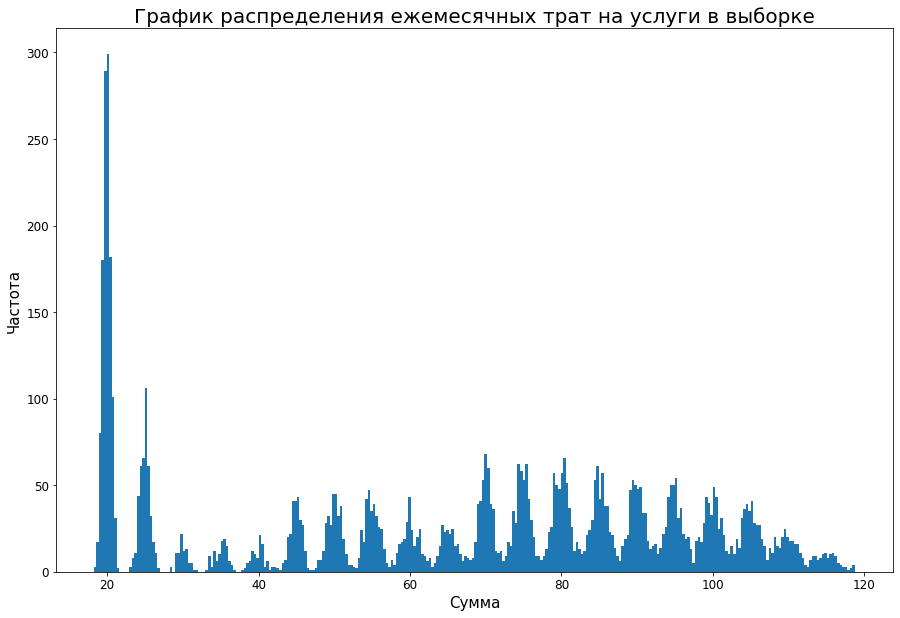

In [12]:
# построение графика распределения ежемесячных трат на услуги
df_contract['MonthlyCharges'].plot(kind="hist",
                                   bins=300,
                                   figsize=(15,10),
                                   fontsize = 12)

plt.title("График распределения ежемесячных трат на услуги в выборке", fontsize=20)
plt.xlabel("Сумма", fontsize=15)
plt.ylabel("Частота", fontsize=15)

In [13]:
# ознакомление с данными
df_contract['TotalCharges'].value_counts()

           11
20.2       11
19.75       9
19.65       8
19.9        8
           ..
6503.2      1
8425.15     1
2258.25     1
119.75      1
5610.7      1
Name: TotalCharges, Length: 6531, dtype: int64

interval columns not set, guessing: ['MonthlyCharges']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable TotalCharges is large: 6531. Are you sure this is not an interval variable? Analysis for pairs of variables including TotalCharges can be slow.
  warnings.warn(


                      Type  PaperlessBilling  PaymentMethod  MonthlyCharges  \
Type              1.000000          0.106860       0.277462        0.388444   
PaperlessBilling  0.106860          1.000000       0.370495        0.467812   
PaymentMethod     0.277462          0.370495       1.000000        0.399526   
MonthlyCharges    0.388444          0.467812       0.399526        1.000000   
TotalCharges      0.945608          0.312983       0.702284        0.954137   

                  TotalCharges  
Type                  0.945608  
PaperlessBilling      0.312983  
PaymentMethod         0.702284  
MonthlyCharges        0.954137  
TotalCharges          1.000000  


<AxesSubplot:>

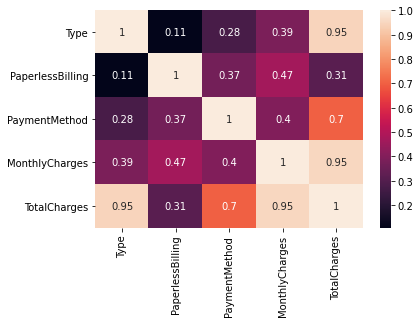

In [14]:
# построение матрицы корреляции для выявления зависимости
# между данными
corr_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

corr_matrix = df_contract.loc[:,corr_columns].phik_matrix()
print(corr_matrix)

sn.heatmap(corr_matrix, annot=True)

#### Вывод

- Данные не содержат строк-дубликатов.
- Столбец `BeginDate` не содержит пропусков.
- Столбец `EndDate` содержит пропуски. Причиной является то, что не все клиенты завершили использование услуг. Будут заменены на дату актуальности данных. Следует отметить: услуги перестают действовать под конец 2019 года и в первый месяц 2020.
- Столбец `Type` не содержит пропусков. Чаще заключают договоры на месяц.
- Столбец `PaperlessBilling` не содержит пропуски. 
- Столбец `PaymentMethod` не содержит пропуски.
- Столбец `MonthlyCharges` не содержит пропуски. Минимальная трата равна 18.25, максимальная - 118.75. Большое скопление трат находится возле показателя 20. Наблюдаются пики в "круглых" показателях трат (рост к пикам, спад после них).
- Столбец `TotalCharges` содерджит пропуски. Будут заменены на значения из столбца `MonthlyCharges`. Не будут удалены, так как наблюдается значительная корреляция.
- Проанализирована корреляция данных. 
    - Значительная зависимость наблюдается между способом оплаты (`PaymentMethod`) и количеством потраченных денег на услуги (`TotalCharges`).
    - Значительная зависимость наблюдается между типом договора (`Type`) и количеством потраченных денег на услуги (`TotalCharges`).
    - Значительная зависимость наблюдается между ежемесячными тратами (`MonthlyCharges`) и количеством потраченных денег на услуги (`TotalCharges`).

### Персональные данные клиента

Файл `internet.csv` содержит информацию о персональных данных клиента.

Содержание столбцов:
- `customerID` - код клиента
- `InternetService` - способ подключение интернета: через телефонную линию или оптоволоконный кабель  
- `OnlineSecurity` - блокировка небезопасных сайтов
- `OnlineBackup` - облачное хранилище файлов для резервного копирования данных 
- `DeviceProtection` - антивирус
- `TechSupport` - выделенная линия технической поддержки
- `StreamingTV` - стриминговое телевидение
- `StreamingMovies` - каталог фильмов 

In [15]:
# чтение файла
try:
    df_internet = pd.read_csv(r"C:\downloads\final_provider\final_provider\internet.csv")
except:
    df_internet = pd.read_csv("/datasets/final_provider/internet.csv")
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [16]:
# просмотр общей информации
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [17]:
# проверка на наличие строк-дубликатов
df_internet.duplicated().sum()

0

In [18]:
# ознакомление с данными
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [19]:
# ознакомление с данными
df_internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [20]:
# ознакомление с данными
df_internet['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [21]:
# ознакомление с данными
df_internet['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [22]:
# ознакомление с данными
df_internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [23]:
# ознакомление с данными
df_internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [24]:
# ознакомление с данными
df_internet['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

                  InternetService  OnlineSecurity  OnlineBackup  \
InternetService          1.000000        0.341950      0.008098   
OnlineSecurity           0.341950        1.000000      0.277245   
OnlineBackup             0.008098        0.277245      1.000000   
DeviceProtection         0.000000        0.263021      0.285491   
TechSupport              0.326553        0.415484      0.293663   
StreamingTV              0.260564        0.065004      0.227275   
StreamingMovies          0.246018        0.084426      0.211500   

                  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  
InternetService           0.000000     0.326553     0.260564         0.246018  
OnlineSecurity            0.263021     0.415484     0.065004         0.084426  
OnlineBackup              0.285491     0.293663     0.227275         0.211500  
DeviceProtection          1.000000     0.360774     0.420014         0.437634  
TechSupport               0.360774     1.000000     0.249535   

<AxesSubplot:>

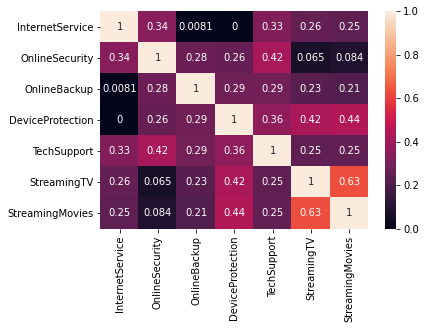

In [25]:
# построение матрицы корреляции для выявления зависимости
# между данными
corr_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

corr_matrix = df_internet.loc[:,corr_columns].phik_matrix()
print(corr_matrix)

sn.heatmap(corr_matrix, annot=True)

#### Вывод

- Данные не содержат пропусков.
- Данные не содержат строк-дубликатов.
- Значительная корреляция наблюдается между `StreamingTV` (стриминговое телевидение) и `StreamingMovies` (каталог фильмов).

### Информация об интернет-услугах

Файл `personal.csv` содержит информацию об интернет-услугах.

Содержание столбцов:
- `customerID` - код клиента
- `gender` - пол 
- `SeniorCitizen` - наличие клиента пенсионного возраста
- `Partner` - партнер
- `Dependents` - наличие иждивенцев

In [26]:
# чтение файла
try:
    df_personal = pd.read_csv(r"C:\downloads\final_provider\final_provider\personal.csv")
except:
    df_personal = pd.read_csv("/datasets/final_provider/personal.csv")
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [27]:
# просмотр общей информации
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [28]:
# проверка на наличие строк-дубликатов
df_personal.duplicated().sum()

0

In [29]:
# ознакомление с данными
df_personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [30]:
# ознакомление с данными
df_personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [31]:
# ознакомление с данными
df_personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [32]:
# ознакомление с данными
df_personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

interval columns not set, guessing: ['SeniorCitizen']
               gender  SeniorCitizen   Partner  Dependents
gender            1.0       0.000000  0.000000    0.000000
SeniorCitizen     0.0       1.000000  0.016992    0.324576
Partner           0.0       0.016992  1.000000    0.652122
Dependents        0.0       0.324576  0.652122    1.000000


<AxesSubplot:>

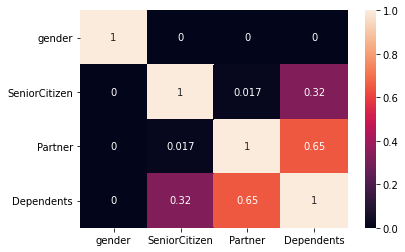

In [33]:
# построение матрицы корреляции для выявления зависимости
# между данными
corr_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

corr_matrix = df_personal.loc[:,corr_columns].phik_matrix()
print(corr_matrix)

sn.heatmap(corr_matrix, annot=True)

#### Вывод

- Данные не содержат пропусков.
- Данные не содержат строк-дубликатов.
- Значительная корреляция наблюдается между `Partner` (партнер) и `Dependents` (наличие иждивенцев).

### Информация об услугах телефонии

Файл `phone.csv` содержит информацию об услугах телефонии.

Содержание столбцов:
- `customerID` - код клиента
- `MultipleLines` - наличие возможности ведения параллельных линий во время звонка

In [34]:
# чтение файла
try:
    df_phone = pd.read_csv(r"C:\downloads\final_provider\final_provider\phone.csv")
except:
    df_phone = pd.read_csv("/datasets/final_provider/phone.csv")
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [35]:
# просмотр общей информации
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [36]:
# проверка на наличие строк-дубликатов
df_phone.duplicated().sum()

0

In [37]:
# ознакомление с данными
df_phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

 #### Вывод

- Данные не содержат пропусков.
- Данные не содержат строк-дубликатов.

### Вывод

Проведён исследовательский анализ 4 файлов. 
- Данные проверены на пропуски.
- Данные проверены на дубликаты.
- Произведена визуализация корреляции.
- Проведён анализ корреляции.
- Отстутствует явный целевой признак, при дальнейшей работе необходимо его выделить.
- Необходимо привести данные к единому регистру.

## План работы

1. Исследовательский анализ данных.
    - Загрузка данных.
    - Проверка на наличие пропусков. 
    - Проверка на наличие дубликатов. 
    - Анализ корреляции. Понимание важности коррелирующих признаков.
2. Предобработка данных.
    - Приведение данных к единому регистру.
    - Устранение пропусков.
    - Устранение дубликатов.
    - Выделение целевого признака из известного столбца `EndDate`.
    - Выделение продолжительности пользования услугами (новый признак) из двух данных столбцов `BeginDate` и `EndDate`.
    - Удаление неинформативных признаков после всех преобразований (`BeginDate` и `EndDate`). 
    - Объединение датафреймов по коду клиента.
3. Обучение моделей.
    - Разделение на выборки: тренировочную и тестовую.
    - Подготовка данных к машинному обучению с учетом используемых моделей. (RandomForest, LogisticRegression, CatBoost, LightGBM). Используем кодирование, масштабирование, изменение типа данных с учетом используемых моделей.
    - Обучение моделей с перебором гиперпараметров.
    - Отслеживание метрики AUC-ROC на кросс-валидации.
    - Выбор лучшей модели.
    - Проверка качества лучшей модели на тестовой выборке.
    - Матрица ошибок.
    - Исследование важности признаков лучшей модели.
4. Отчёт.

## Предобработка данных

### Предобработка данных датафрейма df_contract

In [38]:
# просмотр датафрейма
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [39]:
# приведение заголовков столбцов к нижнему регистру
# приведение данных в отдельных столбцах
# к нижнему регистру для удобства работы с данными
df_contract.columns = df_contract.columns.str.lower()
df_contract['enddate'] = df_contract['enddate'].str.lower()
df_contract['type'] = df_contract['type'].str.lower()
df_contract['paperlessbilling'] = df_contract['paperlessbilling'].str.lower()
df_contract['paymentmethod'] = df_contract['paymentmethod'].str.lower()
df_contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,no,one year,no,mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65


In [40]:
# переименование столбцов
df_contract = df_contract.rename(columns={'customerid':'customer_id', 
                                          'begindate':'begin_date',
                                          'enddate':'end_date',
                                          'paperlessbilling':'paperless_billing',
                                          'paymentmethod':'payment_method',
                                          'monthlycharges':'monthly_charges',
                                          'totalcharges':'total_charges'})
df_contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

#### Устранение пропусков

In [41]:
# замена пропусков (no) в столбце 'end_date' на дату актуальности даннных
df_contract['end_date'] = df_contract['end_date'].replace('no','2020-02-01')
df_contract['end_date'].value_counts()

2020-02-01             5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

In [42]:
# замена пробелов в столбце 'total_charges'
# на соответствующие значения столбца 'monthly_charges'
mc = df_contract.loc[df_contract['total_charges'] == ' ', 'monthly_charges']
df_contract.loc[df_contract['total_charges'] == ' ', 'total_charges'] = mc

In [43]:
# проверка среза
mc

488     52.55
753     20.25
936     80.85
1082    25.75
1340    56.05
3331    19.85
3826    25.35
4380    20.00
5218    19.70
6670    73.35
6754    61.90
Name: monthly_charges, dtype: float64

In [44]:
# проверка данных в столбце 
df_contract['total_charges'].value_counts()

20.2       11
19.75       9
20.05       8
19.9        8
19.65       8
           ..
2258.25     1
119.75      1
109.25      1
1052.4      1
5610.7      1
Name: total_charges, Length: 6541, dtype: int64

#### Выделение целевого признака

In [45]:
# создание собственной функции для категоризации признака
# если клиент ушёл 'customer_care' = 1, остался 'customer_care' = 0
def customer_care(row):
    if row['end_date'] == '2020-02-01':
        return 0
    else:
        return 1
    
# создание нового столбца с вызовом собственной функции
df_contract['customer_care']  = (
          df_contract.apply(customer_care, axis=1))

# проверка результата 
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,customer_care
0,7590-VHVEG,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,one year,no,mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,1


#### Выделение нового признака

Выделение продолжительности пользования услугами из двух данных столбцов `begin_date` и `end_date`.

In [46]:
# приведение данных в столбцах к типу datetime и единому виду
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')

In [47]:
# выделение продолжительности пользования услугами
df_contract['period'] = (df_contract['end_date'] - df_contract['begin_date']).dt.days

In [48]:
# проверка результата 
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,customer_care,period
0,7590-VHVEG,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,one year,no,mailed check,56.95,1889.5,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,month-to-month,yes,mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,month-to-month,yes,electronic check,70.70,151.65,1,61


In [49]:
df_contract['period'].value_counts()

31      431
2191    362
30      182
92      169
2163    164
       ... 
1400      2
1948      2
2070      2
2161      1
1917      1
Name: period, Length: 156, dtype: int64

Text(0, 0.5, 'Частота')

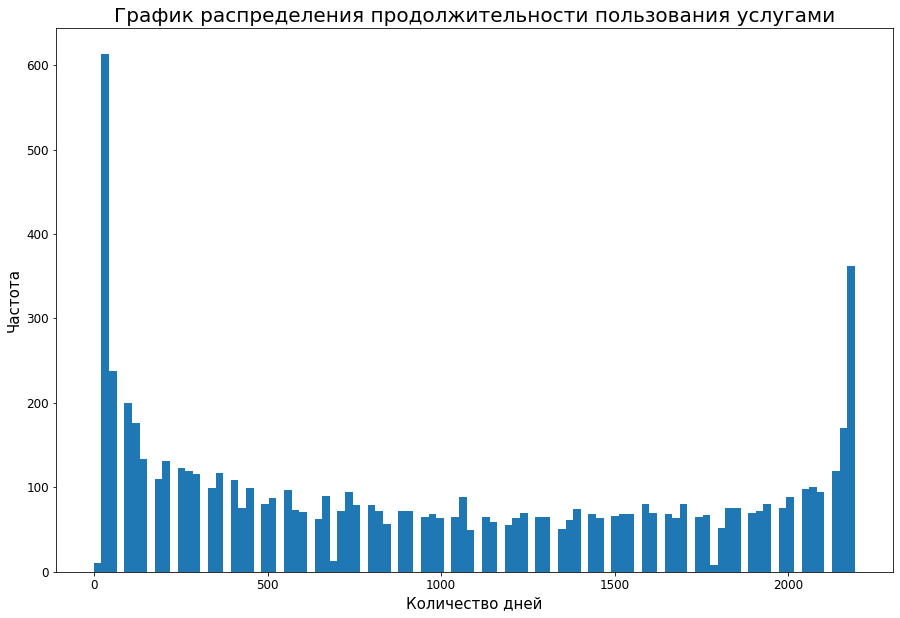

In [50]:
df_contract['period'].plot(kind="hist",
                            bins=100,
                            figsize=(15,10),
                            fontsize = 12)

plt.title("График распределения продолжительности пользования услугами", fontsize=20)
plt.xlabel("Количество дней", fontsize=15)
plt.ylabel("Частота", fontsize=15)

Наблюдается резкий скачок в периоде около месяца. 

#### Удаление неинформативных признаков

In [51]:
# удаление столбцов для исключения выявления лишней зависимости
df_contract = df_contract.drop(['begin_date', 'end_date'], axis=1)
df_contract.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,customer_care,period
0,7590-VHVEG,month-to-month,yes,electronic check,29.85,29.85,0,31
1,5575-GNVDE,one year,no,mailed check,56.95,1889.5,0,1036
2,3668-QPYBK,month-to-month,yes,mailed check,53.85,108.15,1,61
3,7795-CFOCW,one year,no,bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,month-to-month,yes,electronic check,70.70,151.65,1,61


#### Вывод

Проведена предобработка данных в датафрейме `df_contract`.
- Заголовки столбцов и данные в них приведены к виду удобному для работы.
- Устранены пропуски в столбце `end_date`. Заменены на дату актуальности данных.
- Устранены пропуски в столбце `total_charges`. Заменены на соответствующие значения столбца `monthly_charges`.
- Выделен целевой признак `customer_care`. Если клиент ушёл `customer_care` = 1, остался `customer_care` = 0.
- Выделен новый признак продолжительности пользования услугами `period` из двух данных столбцов `begin_date` и `end_date`.
- Удалены столбцы `begin_date` и `end_date` для исключения выявления лишней зависимости.

### Предобработка данных датафрейма df_internet

In [52]:
# просмотр датафрейма
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [53]:
# приведение заголовков столбцов к нижнему регистру
# приведение данных в отдельных столбцах
# к нижнему регистру для удобства работы с данными
df_internet.columns = df_internet.columns.str.lower()
df_internet['internetservice'] = df_internet['internetservice'].str.lower()
df_internet['onlinesecurity'] = df_internet['onlinesecurity'].str.lower()
df_internet['onlinebackup'] = df_internet['onlinebackup'].str.lower()
df_internet['deviceprotection'] = df_internet['deviceprotection'].str.lower()
df_internet['techsupport'] = df_internet['techsupport'].str.lower()
df_internet['streamingtv'] = df_internet['streamingtv'].str.lower()
df_internet['streamingmovies'] = df_internet['streamingmovies'].str.lower()
df_internet.head()

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,dsl,no,yes,no,no,no,no
1,5575-GNVDE,dsl,yes,no,yes,no,no,no
2,3668-QPYBK,dsl,yes,yes,no,no,no,no
3,7795-CFOCW,dsl,yes,no,yes,yes,no,no
4,9237-HQITU,fiber optic,no,no,no,no,no,no


In [54]:
# переименование столбцов
df_internet = df_internet.rename(columns={'customerid':'customer_id', 
                                          'internetservice':'internet_service',
                                          'onlinesecurity':'online_security',
                                          'onlinebackup':'online_backup',
                                          'deviceprotection':'device_protection',
                                          'techsupport':'tech_support',
                                          'streamingtv':'streaming_tv',
                                          'streamingmovies':'streaming_movies'})
df_internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

#### Вывод

Проведена предобработка данных в датафрейме `df_internet`.
- Заголовки столбцов и данные в них приведены к виду удобному для работы.

### Предобработка данных датафрейма df_personal

In [55]:
# просмотр датафрейма
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [56]:
# приведение заголовков столбцов к нижнему регистру
# приведение данных в отдельных столбцах 
# к нижнему регистру для удобства работы с данными
df_personal.columns = df_personal.columns.str.lower()
df_personal['gender'] = df_personal['gender'].str.lower()
df_personal['partner'] = df_personal['partner'].str.lower()
df_personal['dependents'] = df_personal['dependents'].str.lower()
df_personal.head()

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,female,0,yes,no
1,5575-GNVDE,male,0,no,no
2,3668-QPYBK,male,0,no,no
3,7795-CFOCW,male,0,no,no
4,9237-HQITU,female,0,no,no


In [57]:
# переименование столбцов
df_personal = df_personal.rename(columns={'customerid':'customer_id', 
                                          'seniorcitizen':'senior_citizen'})
df_personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

#### Вывод

Проведена предобработка данных в датафрейме `df_personal`.
- Заголовки столбцов и данные в них приведены к виду удобному для работы.

### Предобработка данных датафрейма df_phone

In [58]:
# просмотр датафрейма
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [59]:
# приведение заголовков столбцов к нижнему регистру
# приведение данных в отдельных столбцах 
# к нижнему регистру для удобства работы с данными
df_phone.columns = df_phone.columns.str.lower()
df_phone['multiplelines'] = df_phone['multiplelines'].str.lower()
df_phone.head()

,customerid,multiplelines
0,5575-GNVDE,no
1,3668-QPYBK,no
2,9237-HQITU,no
3,9305-CDSKC,yes
4,1452-KIOVK,yes


In [60]:
# переименование столбцов
df_phone = df_phone.rename(columns={'customerid':'customer_id', 
                                    'multiplelines':'multiple_lines'})
df_phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

#### Вывод

Проведена предобработка данных в датафрейме `df_phone`.
- Заголовки столбцов и данные в них приведены к виду удобному для работы.

### Объединение датафреймов

In [61]:
# объединение датафреймов df_contract и df_personal
df_full = df_contract.merge(df_personal[['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']], 
                            on='customer_id', how='left')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   object 
 6   customer_care      7043 non-null   int64  
 7   period             7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 715.3+ KB


In [62]:
# присоединение датафрейма df_phone
df_full = df_full.merge(df_phone[['customer_id', 'multiple_lines']], on='customer_id', how='outer')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   object 
 6   customer_care      7043 non-null   int64  
 7   period             7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 770.3+ KB


In [63]:
# присоединение датафрейма df_internet
df_full = df_full.merge(df_internet[['customer_id', 'internet_service', 'online_security', 
                                         'online_backup', 'device_protection', 'tech_support', 
                                         'streaming_tv', 'streaming_movies']], on='customer_id', how='outer')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   object 
 6   customer_care      7043 non-null   int64  
 7   period             7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

In [64]:
# проверка объединения
print(df_full.loc[df_full['customer_id']== '3668-QPYBK', ['payment_method', 'internet_service', 'partner', 'multiple_lines']])

print(df_contract.loc[df_contract['customer_id']== '3668-QPYBK', 'payment_method'])

print(df_internet.loc[df_internet['customer_id']== '3668-QPYBK', 'internet_service'])

print(df_personal.loc[df_personal['customer_id']== '3668-QPYBK', 'partner'])

print(df_phone.loc[df_phone['customer_id']== '3668-QPYBK', 'multiple_lines'])

  payment_method internet_service partner multiple_lines
2   mailed check              dsl      no             no
2    mailed check
Name: payment_method, dtype: object
2    dsl
Name: internet_service, dtype: object
2    no
Name: partner, dtype: object
1    no
Name: multiple_lines, dtype: object


In [65]:
# удаление столбца customer_id после объединения таблиц
# для исключения выявления лишних зависимостей
# неинформативный признак
df_full = df_full.drop(['customer_id'], axis=1)

In [66]:
# удаление столбца total_charges 
# после выделения нового признака period 
df_full = df_full.drop(['total_charges'], axis=1)

In [67]:
# проверка на наличие строк-дубликатов
df_full.duplicated().sum()

23

In [68]:
# удаление строк-дубликатов
df_full = df_full.drop_duplicates().reset_index(drop=True)
df_full.duplicated().sum()

0

In [69]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7020 entries, 0 to 7019
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7020 non-null   object 
 1   paperless_billing  7020 non-null   object 
 2   payment_method     7020 non-null   object 
 3   monthly_charges    7020 non-null   float64
 4   customer_care      7020 non-null   int64  
 5   period             7020 non-null   int64  
 6   gender             7020 non-null   object 
 7   senior_citizen     7020 non-null   int64  
 8   partner            7020 non-null   object 
 9   dependents         7020 non-null   object 
 10  multiple_lines     6338 non-null   object 
 11  internet_service   5511 non-null   object 
 12  online_security    5511 non-null   object 
 13  online_backup      5511 non-null   object 
 14  device_protection  5511 non-null   object 
 15  tech_support       5511 non-null   object 
 16  streaming_tv       5511 

In [70]:
# изменение типа данных у столбца total_charges
# df_full['total_charges'] = df_full['total_charges'].astype('float64')

Данные, которые содержат пропуски, категориальные. 
Nan будет выделена в новую категорию `no`.

In [71]:
df_full = df_full.fillna(value = 'no')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7020 entries, 0 to 7019
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7020 non-null   object 
 1   paperless_billing  7020 non-null   object 
 2   payment_method     7020 non-null   object 
 3   monthly_charges    7020 non-null   float64
 4   customer_care      7020 non-null   int64  
 5   period             7020 non-null   int64  
 6   gender             7020 non-null   object 
 7   senior_citizen     7020 non-null   int64  
 8   partner            7020 non-null   object 
 9   dependents         7020 non-null   object 
 10  multiple_lines     7020 non-null   object 
 11  internet_service   7020 non-null   object 
 12  online_security    7020 non-null   object 
 13  online_backup      7020 non-null   object 
 14  device_protection  7020 non-null   object 
 15  tech_support       7020 non-null   object 
 16  streaming_tv       7020 

#### Вывод

- Проведено объединение датафреймов.
- Удалён столбец `customer_id` после объединения таблиц для исключения выявления лишних зависимостей - неинформативный признак.
- Удалены дубликаты.
- Изменён тип данных столбца `total_charges`.
- Пропуски в данных после объединения заменены на `no`. Все данные с пропусками категориальные.

## Обучение моделей

### Дисбаланс 

0    0.7349
1    0.2651
Name: customer_care, dtype: float64


<AxesSubplot:>

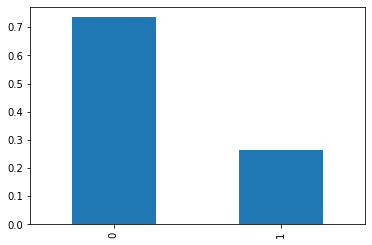

In [72]:
class_frequency = df_full['customer_care'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Заметен явный дисбаланс классов, большее количество человек остались клиентами.

### Разбиение на выборки

In [73]:
# определение целевого признака и признаков 
target = df_full['customer_care']
features = df_full.drop('customer_care', axis=1)

In [74]:
# деление исходного набора данных на две выборки: обучающую и тестовую
# под обучающую отвела 75%, под тестовую - 25%
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.25,
                                                                            random_state=RANDOM_STATE,
                                                                            stratify=target)

In [75]:
# проверка корректности разбиения
print(features_train.shape,
      features_test.shape)

(5265, 17) (1755, 17)


In [76]:
features_train_catboost = features_train.copy(deep=True)
features_train_catboost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5265 entries, 5699 to 3890
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               5265 non-null   object 
 1   paperless_billing  5265 non-null   object 
 2   payment_method     5265 non-null   object 
 3   monthly_charges    5265 non-null   float64
 4   period             5265 non-null   int64  
 5   gender             5265 non-null   object 
 6   senior_citizen     5265 non-null   int64  
 7   partner            5265 non-null   object 
 8   dependents         5265 non-null   object 
 9   multiple_lines     5265 non-null   object 
 10  internet_service   5265 non-null   object 
 11  online_security    5265 non-null   object 
 12  online_backup      5265 non-null   object 
 13  device_protection  5265 non-null   object 
 14  tech_support       5265 non-null   object 
 15  streaming_tv       5265 non-null   object 
 16  streaming_movies   52

### Подготовка данных к машинному обучению с учетом используемых моделей

#### Прямое кодирование

In [77]:
# категориальные признаки 
categorial = features_train.select_dtypes(include='object').columns.to_list()
categorial

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies']

In [78]:
# прямое кодирование категориальных признаков тренировочной выборки для логистической регрессии
encoder_ohe = make_column_transformer(
    (OneHotEncoder(), ['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents',
                       'multiple_lines', 'internet_service', 'online_security', 'online_backup',
                       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']), remainder='passthrough')

ohe = encoder_ohe.fit_transform(features_train)
features_train_ohe = pd.DataFrame(ohe, columns=encoder_ohe.get_feature_names())

#### Масштабирование признаков 

In [79]:
# масштабирование количественных признаков тренировочной выборки для логистической регрессии
pd.options.mode.chained_assignment = None
numeric = ['monthly_charges', 'period', 'senior_citizen']
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])

#### Порядковое кодирование

In [80]:
# порядковое кодирование категориальных признаков тренировочной выборки для случайного леса
encoder = OrdinalEncoder(handle_unknown='ignore')

categorial = ['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'multiple_lines', 
              'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
              'streaming_movies']

features_train_ordinal = features_train.copy()
features_test_ordinal = features_test.copy()

features_train_ordinal[categorial] = encoder.fit_transform(features_train[categorial])
features_test_ordinal[categorial] = encoder.transform(features_test[categorial])

#### Кодирование метки 

In [82]:
# кодирование метки для модели LightGBM
# замена типа object на тип category
features_train[categorial] = features_train[categorial].astype('category')
features_test[categorial] = features_test[categorial].astype('category')

In [83]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5265 entries, 5699 to 3890
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5265 non-null   category
 1   paperless_billing  5265 non-null   category
 2   payment_method     5265 non-null   category
 3   monthly_charges    5265 non-null   float64 
 4   period             5265 non-null   int64   
 5   gender             5265 non-null   category
 6   senior_citizen     5265 non-null   int64   
 7   partner            5265 non-null   category
 8   dependents         5265 non-null   category
 9   multiple_lines     5265 non-null   category
 10  internet_service   5265 non-null   category
 11  online_security    5265 non-null   category
 12  online_backup      5265 non-null   category
 13  device_protection  5265 non-null   category
 14  tech_support       5265 non-null   category
 15  streaming_tv       5265 non-null   category
 16  str

In [84]:
features_category = features_train_catboost.select_dtypes(include='object').columns.to_list()
features_category

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies']

#### Вывод

- Проведено прямое кодирование категориальных признаков для логистической регресии.
- Проведено масштабирование количественных признаков для логистической регресии.
- Проведено порядковое кодирование категориальных признаков для случайного леса.
- Проведено кодирование метки категориальных признаков для LightGBM.

### Обучение моделей

#### Случайный лес

In [85]:
param_grid = [{
    'max_depth': range(1, 15),
    'n_estimators': range(10, 61, 5)
}]

model_1 = RandomForestClassifier(random_state = RANDOM_STATE)
grid_search_forest = GridSearchCV(model_1, param_grid, cv=5, scoring='roc_auc', n_jobs=1)
grid_search_forest.fit(features_train_ordinal, target_train)

auc_roc_forest = grid_search_forest.best_score_

print(f'AUC-ROC Случайного леса: {auc_roc_forest}') 
print(f'Лучшие гиперпараметры: {grid_search_forest.best_params_}')

#dt_estimator_

AUC-ROC Случайного леса: 0.8558808584635189
Лучшие гиперпараметры: {'max_depth': 8, 'n_estimators': 60}


#### Логистическая регрессия

In [87]:
model_2 = LogisticRegression(random_state = RANDOM_STATE, 
                             solver = 'lbfgs') 
result_2 = cross_val_score(model_2, features_train_ohe, target_train, cv=5, scoring='roc_auc').mean() 
print('Лучшее значение AUC-ROC:', result_2)

Лучшее значение AUC-ROC: 0.8423027863040833


#### CatBoost

In [88]:
best_model_catboost = None
best_result_catboost = 0
best_depth = 0 

for depth in range(1,20):
    model_catboost = CatBoostClassifier(iterations = 40, 
                                        max_depth = depth,
                                        cat_features=features_category, 
                                        random_state = RANDOM_STATE,
                                        verbose=0)
    result_catboost = cross_val_score(model_catboost, features_train_catboost, target_train,
                                          cv = 5, scoring = 'roc_auc')
    result_catboost = np.mean(result_catboost)
        
    if result_catboost > best_result_catboost:
        best_model_catboost = model_catboost
        best_result_catboost = result_catboost
        best_depth = depth
        
print('Лучшее значение AUC-ROC:', best_result_catboost,
      'Глубина дерева:', best_depth)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line

Лучшее значение AUC-ROC: 0.8707470624030197 Глубина дерева: 7


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line

#### LightGBM

In [89]:
param_grid = [{
    'max_depth': [5, 10, 15],
    'num_leaves':[31, 100, 200],
    'learning_rate': [0.01, 0.1, 0.15]
}]

model_light = LGBMClassifier(random_state = RANDOM_STATE,
                             n_jobs=1)
grid_search_light = GridSearchCV(model_light, param_grid, cv=5, scoring='roc_auc')
grid_search_light.fit(features_train, target_train)

auc_roc_light = grid_search_light.best_score_

print(f'AUC-ROC LGBM: {auc_roc_light}') 
print(f'Лучшие гиперпараметры: {grid_search_light.best_params_}')

AUC-ROC LGBM: 0.8939330602156416
Лучшие гиперпараметры: {'learning_rate': 0.15, 'max_depth': 10, 'num_leaves': 31}


In [91]:
df = pd.DataFrame({'модель': ['RandomForest', 'LogisticRegression', 'CatBoost', 'LightGBM'], 
                   'AUC-ROC': [auc_roc_forest, result_2, best_result_catboost, auc_roc_light]})
df

,модель,AUC-ROC
0,RandomForest,0.855881
1,LogisticRegression,0.842303
2,CatBoost,0.870747
3,LightGBM,0.893933


#### Проверка лучшей модели

In [104]:
# проверка на тестовой выборке лучшей модели
model_light = LGBMClassifier(learning_rate = 0.15, 
                             max_depth = 10, 
                             num_leaves = 31, 
                             random_state = RANDOM_STATE)
model_light.fit(features_train, target_train)
predictions_test = model_light.predict_proba(features_test)
print("AUC-ROC:", roc_auc_score(target_test, predictions_test[:, 1]))

AUC-ROC: 0.9082103859298158


#### Матрица ошибок и оценка важности признаков

In [110]:
# матрица ошибок 
predictions_test = model_light.predict(features_test)

confusion_matrix(target_test, predictions_test)

array([[1210,   80],
       [ 163,  302]])

- True Positive (TP) = 1210; это означает, что 1210 положительных точек данных были правильно классифицированы моделью.
- True Negative (TN) = 80; это означает, что 80 отрицательных точек данных были правильно классифицированы моделью.
- False Positive (FP) = 163; это означает, что 163 отрицательных точек данных были неправильно классифицированы моделью как положительные.
- False Negative (FN) = 302; это означает, что 302 положительных точек данных были неправильно классифицированы моделью как отрицательные.

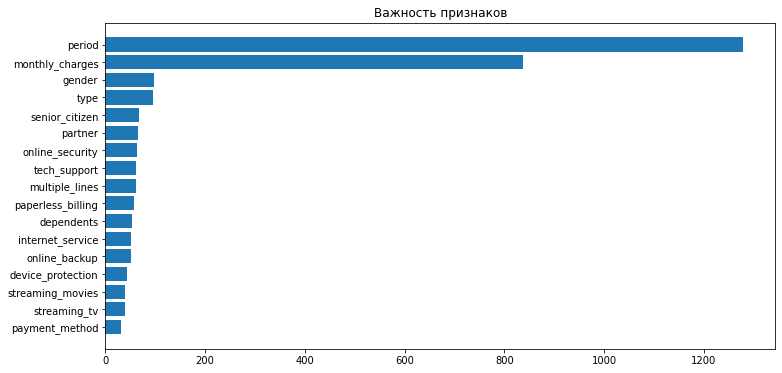

In [111]:
# оценка важности признаков
feature_importance = model_light.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Важность признаков');

Большую важность имеют такие признаки, как `period` и `monthly_charges`.

#### Вывод

- Проведено обучение моделей RandomForest, LogisticRegression, CatBoost, LightGBM.
- Лучший результат показала модель LightGBM с параметрами learning_rate = 0.15, max_depth = 10,  num_leaves = 31, random_state = 261222.
- Лучшая модель проверена на тестовой выборке.
- Построена матрица ошибок.
- Проведена оценка важности признаков.

### Вывод

Построена модель для прогнозирования оттока клиентов.

## Отчёт

Построена модель для прогнозирования оттока клиентов.

Все пункты первоначального плана выполнены:
- Исследовательский анализ данных.
- Предобработка данных.
- Обучение моделей.

После объединения датафреймов образовались пропуски, которые были устранены заменой на `no`.

Было важно грамотно подготовить данные для качественного обучения моделей, а именно:
- обработать пропуски;
- устранить неинформативные признаки;
- правильно разбить на выборки;
- предобработать признаки к машинному обучению с учетом используемых моделей.

По итогу проведённой работы лучший результат (метрика качества AUC-ROC = 0.9082103859298158) показала модель `LightGBM` с параметрами:
- learning_rate = 0.15; 
- max_depth = 10;
- num_leaves = 31;
- random_state = 261222.

Как проходила подготовка признаков для `LightGBM`:
- Данные были разбиты на признаки и целевой признак `customer_care`.
- Проведено кодирование метки тренировочных и тестовых категориальных признаков - замена типа `object` на тип `category`.
- Для обучения и перебора гиперпараметров использовался оптимизатор GridSearchCV.